# SLT-CE-4: Histogram Clustering

In this coding exercise you will apply histogram clustering (HC) in order to segment an image. You will implement two different methods (maximum a posterior (MAP) and deterministic annealing (DA)) in order to predict the clusters membership for each pixel.

<h2 style="background-color:#f0b375;"> References </h2>

<ol>
<li> Histogram clustering for unsupervised image segmentation: http://ieeexplore.ieee.org/document/784981/
</li>
<li> Lecture Slides 4: https://ml2.inf.ethz.ch/courses/slt/lectures/slt19_lecture04.pdf
</li>
<li> Lecture script: https://ml2.inf.ethz.ch/courses/slt/tutorials/SLT_Script.pdf
</li>
</ol>

<h2 style="background-color:#f0b375;"> Setup </h2>

In [2]:
import sklearn as skl
import matplotlib.pyplot as plt
import numpy as np

from sklearn.utils.validation import check_is_fitted
from matplotlib.image import imread

import scipy as sp
import scipy.signal as sps

## Texture and corresponding label map
(This texture is used to fit your model.)

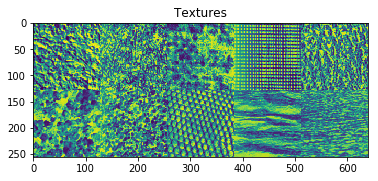

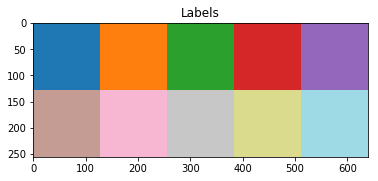

In [3]:
texture = imread("texture.png")

patch_grid_shape = (2,5)
patch_shape = (128,128)
label_map = np.ones(texture.shape)
for patch in range(np.prod(patch_grid_shape)):
    i, j = np.unravel_index(patch, patch_grid_shape)
    label_map[patch_shape[0] * i : patch_shape[0] * (i + 1), \
              patch_shape[1] * j : patch_shape[1] * (j + 1)] = np.ravel_multi_index((i,j), patch_grid_shape)

plt.imshow(texture)
plt.title("Textures")
plt.figure()
plt.imshow(label_map, cmap="tab20")
plt.title("Labels")
plt.show()

## Permuted texture and label map
(The permuted texture is used for the prediction)

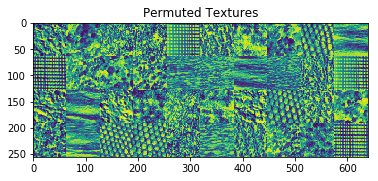

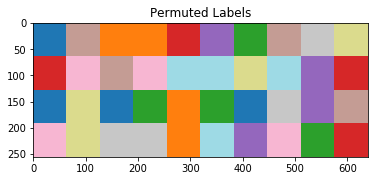

In [4]:
perm_patch_grid_shape = tuple(i * 2 for i in patch_grid_shape)
perm_patch_shape = tuple(i//2 for i in patch_shape)
n_perm_patches = np.prod(patch_grid_shape) * 4

np.random.seed(5)
perm = np.random.permutation(n_perm_patches)

perm_texture = np.ones(texture.shape)
perm_label_map = np.ones(texture.shape)

for patch, perm_patch in enumerate(perm):
    i, j = np.unravel_index(patch, perm_patch_grid_shape)
    ip, jp = np.unravel_index(perm_patch, perm_patch_grid_shape)
    
    perm_texture[ip * perm_patch_shape[0] : (ip + 1) * perm_patch_shape[0], \
                 jp * perm_patch_shape[1] : (jp + 1) * perm_patch_shape[1]] = \
    texture[i * perm_patch_shape[0] : (i + 1) * perm_patch_shape[0], \
            j * perm_patch_shape[1] : (j + 1) * perm_patch_shape[1]]
    
    perm_label_map[ip * perm_patch_shape[0] : (ip + 1) * perm_patch_shape[0], \
                   jp * perm_patch_shape[1] : (jp + 1) * perm_patch_shape[1]] = \
    label_map[i * perm_patch_shape[0] : (i + 1) * perm_patch_shape[0], \
              j * perm_patch_shape[1] : (j + 1) * perm_patch_shape[1]]
    
plt.imshow(perm_texture)
plt.title("Permuted Textures")
plt.figure()
plt.imshow(perm_label_map, cmap="tab20")
plt.title("Permuted Labels")
plt.show()

<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
    Read the references and recapitulate the parameter estimation formulas for both, Maximum a Posteriori estimation and Deterministic Annealing (DA) estimation. In particular, write down how equation (5) in reference [1] looks for the case of DA (using the notation of reference [1]). Hint: try to reformulate $\hat P(y|c)$ in terms of $\hat P(c|x)$ and use the maximum entropy principle to find an expression for $\hat P(c|x)$.
</p>

Put your recap here

For MAP, the centroids can be found directly by $$ \hat p(y | c) = \sum_{x: \hat c(x) = c} \frac{n(x)}{\sum_{x': \hat c(x') = c)} n(x')} \hat p(y | x) .$$


In the case of DA, equation (5) becomes $$\hat{P}(y|c) = \frac{\sum_{x \in \mathcal X} \hat p(y|x) p(c(x) = c)}{\sum_{x \in \mathcal X} p(c(x) = c)},$$ where
$$ P(c(x) = c) = \frac{\exp\left(-n(x)D_\text{KL}\left[\hat p(\cdot | x) || \hat p (\cdot | c) \right] / T\right)}{\sum_{c'=1}^K \exp\left(-n(x)D_\text{KL}\left[\hat p(\cdot | x) || \hat p (\cdot | c') \right] /T\right)}. $$

In [5]:
class HistogramClustering(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for HistogramClustering (HC)
    
    Attributes:
        centroids (np.ndarray): Array of centroid distributions p(y|c) with shape (n_clusters, n_bins).
        
    Parameters:
        n_clusters (int): Number of clusters (textures).
        n_bins (int): Number of bins used to discretize the range of pixel values found in input image X.
        window_size (int): Size of the window used to compute the local histograms for each pixel.
                           Should be an odd number larger or equal to 3.
        random_state (int): Random seed.
        estimation (str): Whether to use Maximum a Posteriori ("MAP") or
                          Deterministic Annealing ("DA") estimation.
    """
    
    def __init__(self, n_clusters=10, n_bins=64, window_size=7, random_state=42, estimation="MAP"):
        self.n_clusters = n_clusters
        self.n_bins = n_bins
        self.window_size = window_size
        self.random_state = random_state
        self.estimation = estimation
        # Add more parameters, if necessary.
    
    def fit(self, X):
        """Compute HC for input image X
        
        Compute centroids.        
        
        Args:
            X (np.ndarray): Input array with shape (height, width)
        
        Returns:
            self
        """
        
        if self.estimation == "MAP":
            
            # Code for Maximum a Posteriori estimation
            
            X = (X * (self.n_bins-1)).astype(np.uint8)
            
            one_hot = np.zeros( (X.size, self.n_bins))
            one_hot[np.arange(X.size), X.ravel()] = 1
            one_hot.shape = X.shape + (self.n_bins,)

            # scipy version needs to be >= 1.2.1 for fftconvolve to support axes keyword
            cooccur = sp.sparse.csr_matrix(np.round(sps.fftconvolve(one_hot, np.ones((self.window_size, self.window_size, self.n_bins)), 'same', axes=[0,1])).astype(int).reshape(-1, self.n_bins))
            x_occur = np.sum(cooccur, axis=-1).A
            p_y_given_x = sp.sparse.csr_matrix(cooccur / x_occur) # shape (height * width, 256)
        
        
            self.centroids = np.zeros((self.n_bins, self.n_clusters))
            self.centroids += 1/self.n_bins # assume uniform
            
            for epoch in range(15):
                # shape (height * width)
                x2cluster = np.argmin(-p_y_given_x.dot(np.log(self.centroids)), axis=-1)
                
                sort_idx = np.argsort(x2cluster)
                unique, counts = np.unique(x2cluster, return_counts=True)
                cluster2x = {key: sort_idx[sum(counts[:key]): sum(counts[:key]) + counts[key]] for key in unique}
                
                for key, idx in cluster2x.items():
                    self.centroids[:, key] = np.sum((cooccur / np.sum(x_occur[idx]))[idx], axis=0)
                
        
        elif self.estimation == "DA":
            
            # Code for Deterministic Annealing estimation
            import scipy.special

            temperature = 100
            temp_decay = .95
            
            X = (X * (self.n_bins-1)).astype(np.uint8)
            
            one_hot = np.zeros( (X.size, self.n_bins))
            one_hot[np.arange(X.size), X.ravel()] = 1
            one_hot.shape = X.shape + (self.n_bins,)

            # scipy version needs to be >= 1.2.1 for fftconvolve to support axes keyword
            cooccur = sp.sparse.csr_matrix(np.round(sps.fftconvolve(one_hot, np.ones((self.window_size, self.window_size, self.n_bins)), 'same', axes=[0,1])).astype(int).reshape(-1, self.n_bins))
            x_occur = np.sum(cooccur, axis=-1).A
            p_y_given_x = (cooccur / x_occur).A # shape (height * width, 256)
            p_y_given_x += 1e-4
            p_y_given_x /= np.sum(p_y_given_x, axis=1)[:, None]
        
            self.centroids = np.zeros((self.n_bins, self.n_clusters))
            self.centroids += np.random.normal(scale=1, size=(self.n_bins, self.n_clusters))
            self.centroids = np.abs(self.centroids)
            self.centroids += 1e-4
            self.centroids /= np.sum(self.centroids, axis=0)
        
            i = 0
        
            self.histories = {}
        
            while temperature > 0.5:
                print('Temperature:', temperature)
                for epoch in range(1):
                    # shape (n_samples, n_centroids)
                    kl = np.sum(p_y_given_x[:, None] * np.log(p_y_given_x[:, None] / self.centroids.T[None, :]), axis=-1)
                    probs = np.exp(-x_occur * kl / temperature)
                    probs /= np.sum(probs, axis=1)[:, None]
#                     print(np.sum(probs, axis=0) / cooccur.shape[0])
                    self.centroids = p_y_given_x.T.dot(probs) / np.sum(probs, axis=0)
#                     print(self.centroids.T[:, :5])
                
                if i % 5 == 0:
                    self.histories[temperature] = self.centroids

                temperature *= temp_decay
                i += 1

            
        return self
    
    def predict(self, X):
        """Predict cluster assignments for each pixel in image X.
        
        Args:
            X (np.ndarray): Input array with shape (height, width)
            
        Returns:
            C (np.ndarray): Assignment map (height, width) 
        """
        check_is_fitted(self, ["centroids"])
        
        # Your code goes here
        X = (X * (self.n_bins-1)).astype(np.uint8)
        one_hot = np.zeros( (X.size, self.n_bins))
        one_hot[np.arange(X.size), X.ravel()] = 1
        one_hot.shape = X.shape + (self.n_bins,)

        # scipy version needs to be >= 1.2.1 for fftconvolve to support axes keyword
        cooccur = sp.sparse.csr_matrix(np.round(sps.fftconvolve(one_hot, np.ones((self.window_size, self.window_size, self.n_bins)), 'same', axes=[0,1])).astype(int).reshape(-1, self.n_bins))
        x_occur = np.sum(cooccur, axis=-1).A
        p_y_given_x = sp.sparse.csr_matrix(cooccur / x_occur) # shape (height * width, 256)
        C = np.argmin(-p_y_given_x.dot(np.log(self.centroids)), axis=-1)
        
        return C.reshape(X.shape)
    
    def generate(self, C):
        """Generate a sample image X from a texture label map C.
        
        The entries of C are integers from the set {1,...,n_clusters}. They represent the texture labels
        of each pixel. Given the texture labels, a sample image X is generated by sampling
        the value of each pixel from the fitted p(y|c).
        
        Args:
            C (np.ndarray): Input array with shape (height, width)
            
        Returns:
            X (np.ndarray): Sample image (height, width)
        """
        check_is_fitted(self, ["centroids"])
        
        # Your code goes here
        
        probs = self.centroids[:, C.reshape(-1)]
        X = np.zeros_like(C.reshape(-1))
        
        for idx, _ in enumerate(X):
            X[idx] = np.random.choice(self.n_bins, 1, p=probs[:, idx])
        
        X = X.reshape(C.shape) / self.n_bins * 255
        
        return X
        

<p style="background-color:#adebad;">
Implement the "MAP" part of the <b>fit method</b> for the template class HistogramClustering, according to the contract outlined in its docstring. You can add more class methods if necessary. Create an instance of your HC class with n_clusters = 10 and fit the image texture. Record the execution time.
</p>

In [6]:
%%time
HC = HistogramClustering()
HC.fit(texture)
check_is_fitted(HC, ["centroids"])

/home/mcreng/anaconda3/envs/slt-ce/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log


CPU times: user 6.16 s, sys: 1.15 s, total: 7.3 s
Wall time: 3.94 s


<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
    <ul style="background-color:#adebad;">
        <li> Implement the <b>predict method</b> for the template class HC, according to the contract outlined in its docstring.
        </li>        
        <li>
            Use HC.predict to predict the texture labels of perm_texture. Plot the predicted label map.
        </li>
    </ul>
</p>

In [7]:
%%time
predicted_perm_label_map = HC.predict(perm_texture)

CPU times: user 1.35 s, sys: 587 ms, total: 1.94 s
Wall time: 1.27 s


/home/mcreng/anaconda3/envs/slt-ce/lib/python3.5/site-packages/ipykernel_launcher.py:140: RuntimeWarning: divide by zero encountered in log


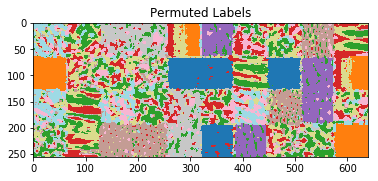

In [8]:
plt.imshow(predicted_perm_label_map, cmap="tab20")
plt.title("Permuted Labels")
plt.show()

<p style="background-color:#adebad;">
    Plot a confusion matrix for your predictions, using the perm_label_map. Make sure to permute the texture labels appropriately, so that they are in correpondence with the true labels.
</p>

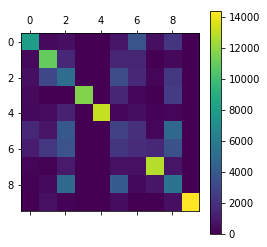

In [9]:
# Confusion matrix
import sklearn.metrics

def cmsort(m, cnt=0, mask=None):
    m = m.copy()
    if m.shape[0] == cnt: return m
    if mask is None:
        amax = np.unravel_index(np.argmax(m, axis=None), m.shape)
    else:
        amax = np.unravel_index(np.ma.argmax(np.ma.array(m, mask=~mask), axis=None), m.shape)
    m[:, [*amax]] = m[:, [*np.flip(amax, axis=0)]]
    if mask is None: mask = np.ones(m.shape, dtype=bool)
    mask[:, amax[0]] = 0
    mask[amax[0], :] = 0
    return cmsort(m.reshape((m.shape[0], m.shape[1])), cnt+1, mask)

def argcmsort(m):
    m = m.copy()
    sortedm = cmsort(m.copy())
    arr = [0] * m.shape[0]
    for idx, col in enumerate(sortedm.T):
        arr[idx] = np.where(np.all(m.T == col, axis=1))[0][0]
    return arr

m = skl.metrics.confusion_matrix(perm_label_map.reshape(-1), predicted_perm_label_map.reshape(-1))
plt.figure()
plt.matshow(cmsort(m))
plt.colorbar()
plt.show()

<p style="background-color:#adebad;">
    Using n_clusters=10, fit HC with all combinations of n_bins = 16, 32, 64 and window_size = 7, 9, 11.
    For each setting compute the accuracy of the prediction on perm_texture. Show the results in a 3x3 matrix and label the axes properly.
</p>

In [10]:
# 3x3 Matrix with accuracy scores of the different parameter combination
maps = []
for n_bins in [16, 32, 64]:
    for window_size in [7, 9, 11]:
        HC = HistogramClustering(n_bins=n_bins, window_size=window_size)
        HC.fit(texture)
        maps.append((n_bins, window_size, HC.predict(perm_texture)))

/home/mcreng/anaconda3/envs/slt-ce/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log
/home/mcreng/anaconda3/envs/slt-ce/lib/python3.5/site-packages/ipykernel_launcher.py:140: RuntimeWarning: divide by zero encountered in log


In [11]:
accuracies = []
for n_bins, window_size, m in maps:
    cm = skl.metrics.confusion_matrix(perm_label_map.reshape(-1), m.reshape(-1))
    order = np.array(argcmsort(cm))
    accuracies.append((n_bins, window_size, skl.metrics.accuracy_score(perm_label_map.reshape(-1), order[m.reshape(-1)])))

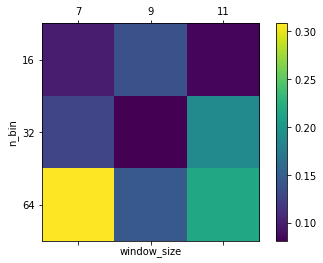

In [12]:
accuaracies_matrix = np.array(list(map(lambda v: v[-1], accuracies))).reshape(3,3)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(accuaracies_matrix)

ax.set_xticklabels([None, 7, 9, 11])
ax.set_xlabel('window_size')
ax.set_yticklabels([None, 16, 32, 64])
ax.set_ylabel('n_bin')
fig.colorbar(cax)
plt.show()

<p style="background-color:#adebad;">
    For each setting plot the prediction (i.e. the clustering) of the texture (perm_texture) itself. Arrange the plots next to each other in a grid and label them properly.
    </p>

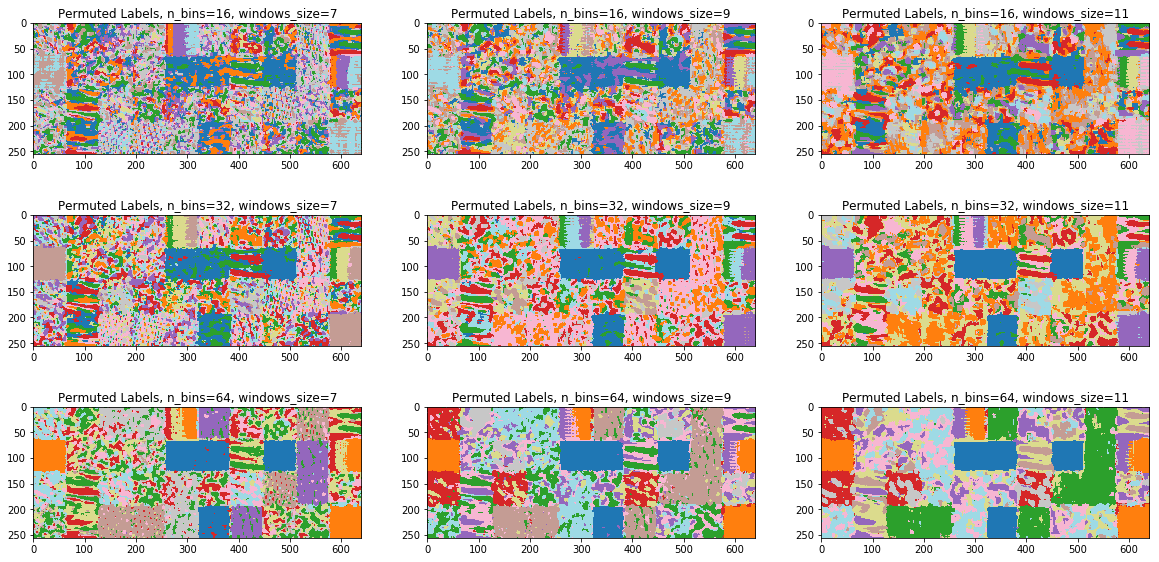

In [13]:
# Cluster predictions (9 plots arranged in a 3x3 grid)
fig = plt.figure(figsize=(20, 10))
for idx, (n_bins, window_size, m) in enumerate(maps):
    ax = fig.add_subplot(3, 3, idx+1)
    ax.imshow(m, cmap="tab20")
    ax.set_title("Permuted Labels, n_bins={}, windows_size={}".format(n_bins, window_size))
plt.show()

<h2 style="background-color:#f0b375;">
Section 5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5 </span>
</h2>

<ul style="background-color:#adebad;">
        <li> Implement the <b>generate method</b> for the template class HC, according to the contract outlined in its docstring.
        </li>
        <li>
        Use HC.generate to generate ten 128x128 patches, one for each texture. Plot the generated textures next to the ground truth textures. Additionally, for each such pair, plot a histogram comparing the distribution of their pixel intensity values. 
        </li>
    </ul>

In [14]:
HC = HistogramClustering()
HC.fit(texture)
check_is_fitted(HC, ["centroids"])

/home/mcreng/anaconda3/envs/slt-ce/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log


/home/mcreng/anaconda3/envs/slt-ce/lib/python3.5/site-packages/ipykernel_launcher.py:140: RuntimeWarning: divide by zero encountered in log


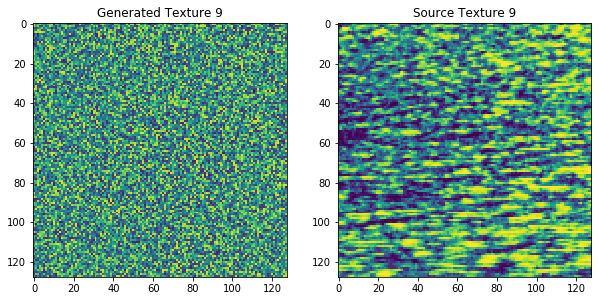

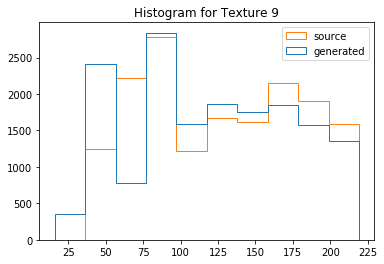

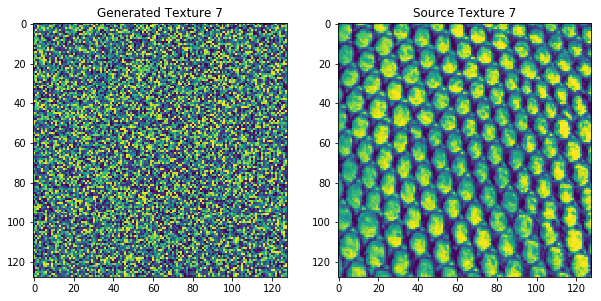

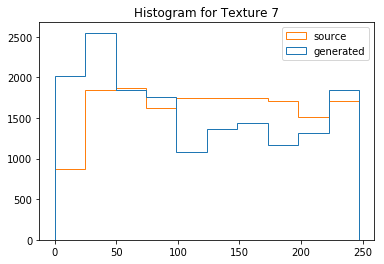

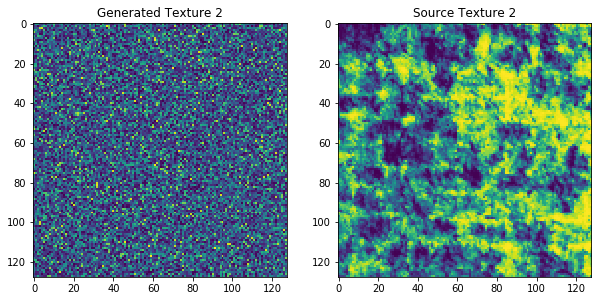

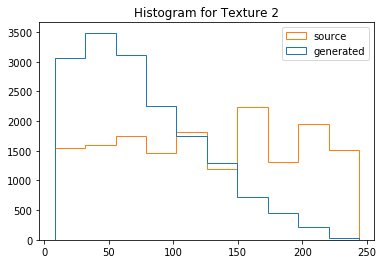

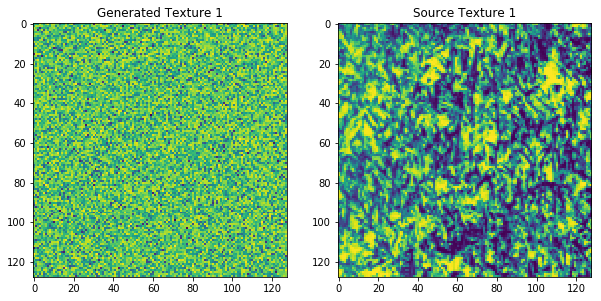

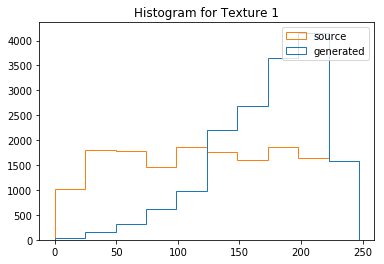

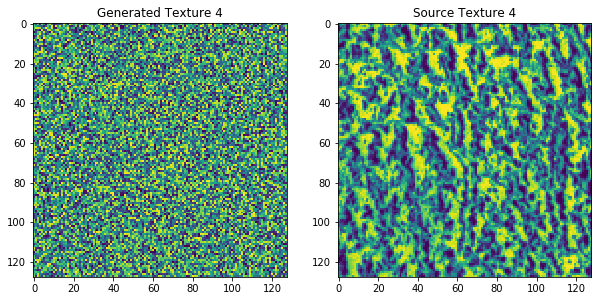

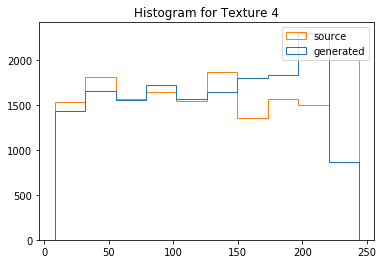

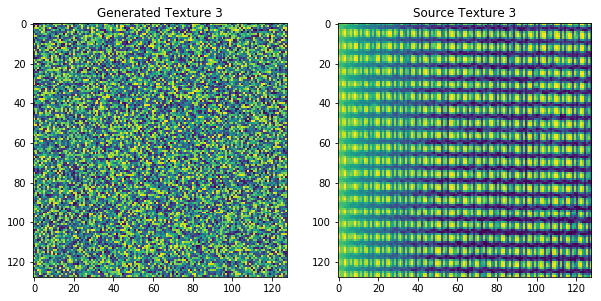

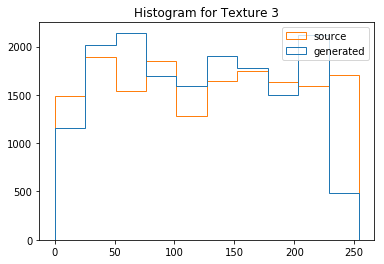

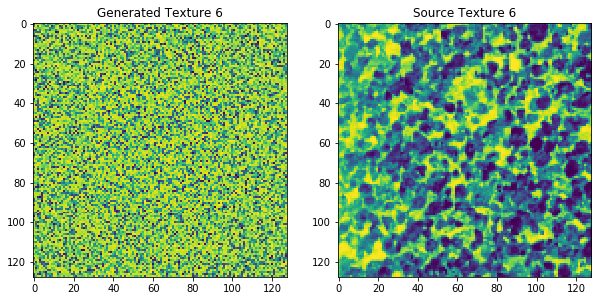

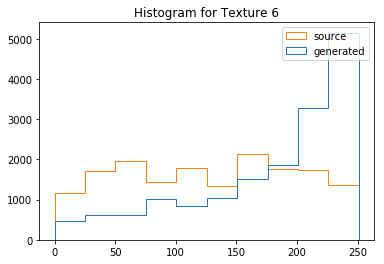

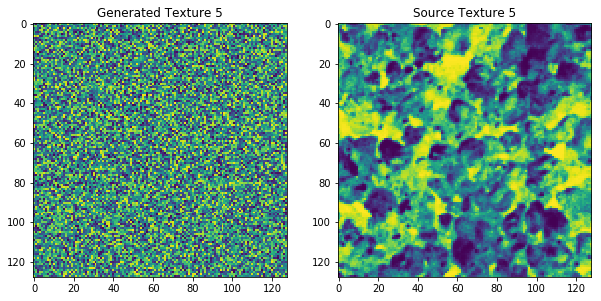

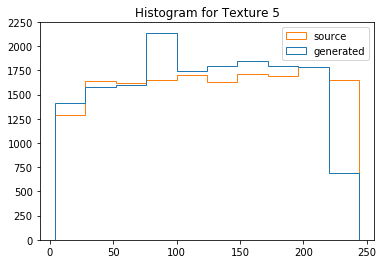

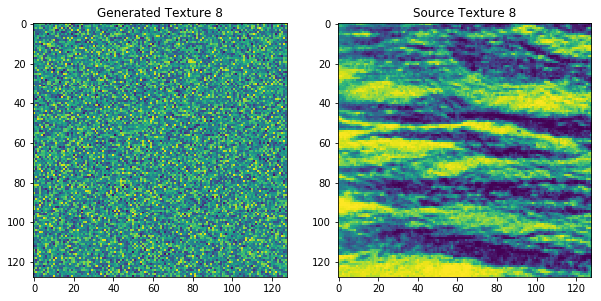

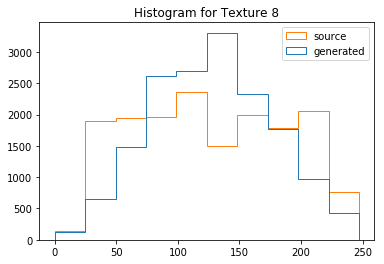

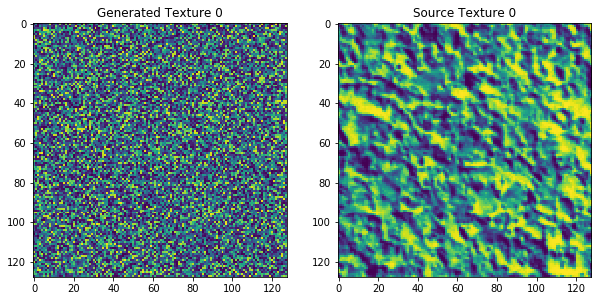

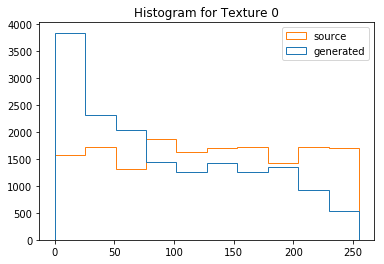

In [15]:
# Generated texture plot
arg = argcmsort(skl.metrics.confusion_matrix(perm_label_map.reshape(-1), HC.predict(perm_texture).reshape(-1)))

for i in range(10):
    C = (np.ones(patch_shape) * i).astype(int)
    X = HC.generate(C)
    fig = plt.figure(figsize=(10, 5))
    fig.add_subplot(121)
    plt.imshow(X)
    plt.title("Generated Texture {}".format(arg[i]))
    fig.add_subplot(122)
    plt.imshow(np.hstack([texture[:128], texture[128:]]).reshape(128, 10, 128)[:, arg[i], :])
    plt.title("Source Texture {}".format(arg[i]))
    plt.figure()
    plt.hist([X.reshape(-1),
              np.hstack([texture[:128], texture[128:]]).reshape(128, 10, 128)[:, arg[i], :].reshape(-1) * 255]
             , histtype='step', label=['generated', 'source'])
    plt.title("Histogram for Texture {}".format(arg[i]))
    plt.legend()
    plt.show()

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<ul style="background-color:#adebad;">
    <li>
        Use k-means clustering to cluster the pixels of the texture (perm_texture). Set n_clusters=10, and use the local histogram vectors as features. Compare the predicted label map with k-means with the predicted label map obtained by HC.
    </li>
</ul>

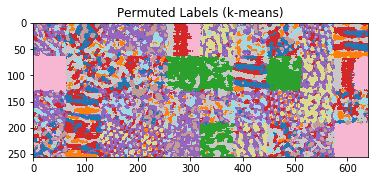

/home/mcreng/anaconda3/envs/slt-ce/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log
/home/mcreng/anaconda3/envs/slt-ce/lib/python3.5/site-packages/ipykernel_launcher.py:140: RuntimeWarning: divide by zero encountered in log


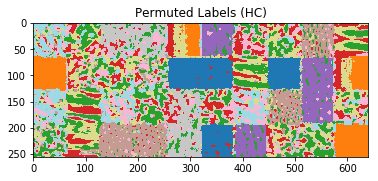

In [18]:
# Predicted label map for k-means
# Predicted label map for HC
import sklearn.cluster
kmeans = skl.cluster.KMeans(n_clusters=10)

X = (perm_texture * (64-1)).astype(np.uint8)

one_hot = np.zeros((X.size,64))
one_hot[np.arange(X.size), X.ravel()] = 1
one_hot.shape = X.shape + (64, )

# scipy version needs to be >= 1.2.1 for fftconvolve to support axes keyword
cooccur = (np.round(sps.fftconvolve(one_hot, np.ones((7, 7, 64)), 'same', axes=[0,1])).astype(int).reshape(-1, 64))
x_occur = np.sum(cooccur, axis=-1)
p_y_given_x = cooccur / x_occur[:, None] # shape (height * width, 64)
kmeans_predicted_perm_label_map = kmeans.fit_predict(p_y_given_x)
plt.figure()
plt.imshow(kmeans_predicted_perm_label_map.reshape(perm_texture.shape), cmap='tab20')
plt.title('Permuted Labels (k-means)')
plt.show()
HC = HistogramClustering()
HC.fit(texture)
predicted_perm_label_map = HC.predict(perm_texture)
plt.imshow(predicted_perm_label_map, cmap="tab20")
plt.title("Permuted Labels (HC)")
plt.show()

<ul style="background-color:#adebad;">
    <li>
        Moreover, plot and compare the confusion matrices for both, K-means, and HC.
    </li>
</ul>

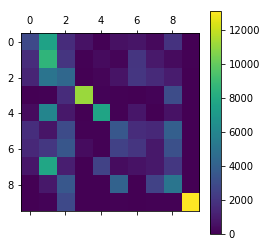

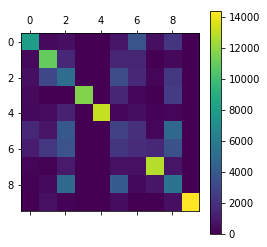

In [19]:
# Confusion matrices
m = skl.metrics.confusion_matrix(perm_label_map.reshape(-1), kmeans_predicted_perm_label_map.reshape(-1))
plt.figure()
plt.matshow(cmsort(m))
plt.colorbar()
m = skl.metrics.confusion_matrix(perm_label_map.reshape(-1), predicted_perm_label_map.reshape(-1))
plt.figure()
plt.matshow(cmsort(m))
plt.colorbar()
plt.show()

<ul style="background-color:#adebad;">
        <li>
        Plot the centroid histograms $\hat P(y|c)$ after fitting the texture image. Compare them to the empirical histograms (i.e. show them both in one plot).
        </li>
    </ul>

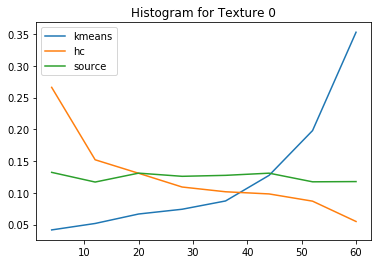

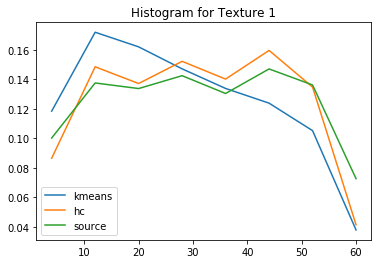

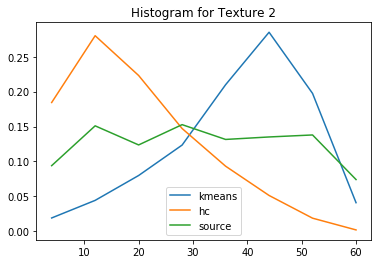

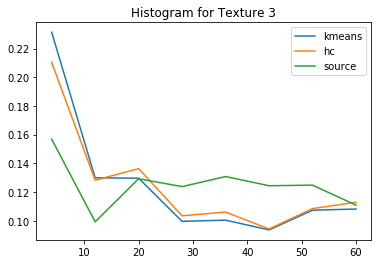

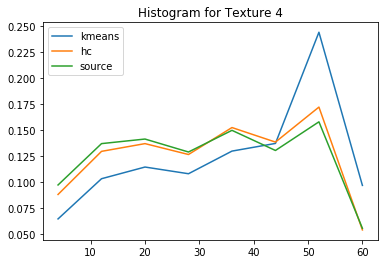

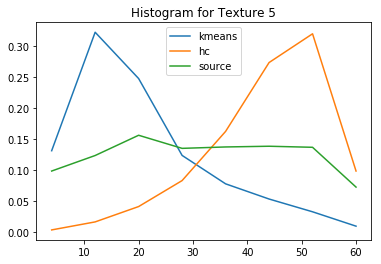

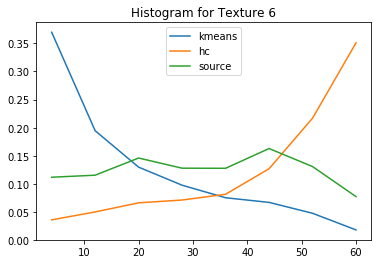

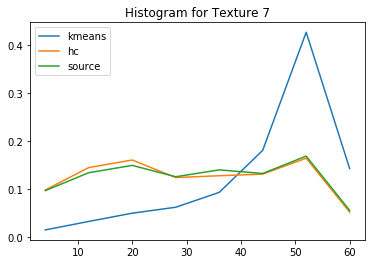

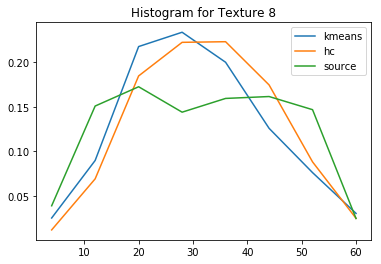

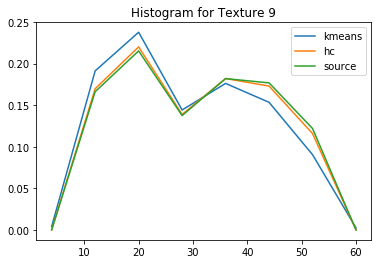

In [20]:
# Histograms
m = skl.metrics.confusion_matrix(perm_label_map.reshape(-1), kmeans_predicted_perm_label_map.reshape(-1))
arg_kmeans = argcmsort(m)
m = skl.metrics.confusion_matrix(perm_label_map.reshape(-1), predicted_perm_label_map.reshape(-1))
arg_hc = argcmsort(m)

for idx, (cl, cll) in enumerate(zip(kmeans.cluster_centers_[arg_kmeans], HC.centroids.T[arg_hc])):
    plt.figure()
    
    plt.plot(8*np.arange(8) + 4, (cl.reshape(-1, 8).sum(1)), label='kmeans')
    plt.plot(8*np.arange(8) + 4, (cll.reshape(-1, 8).sum(1)), label='hc')
    
    h, b = np.histogram(np.hstack([texture[:128] / 255 * 63, texture[128:] / 255 * 63]).reshape(128, 10, 128)[:, idx, :].reshape(-1) * 255, bins=8*np.arange(9))
    plt.plot((b[1:] + b[:-1]) / 2, h / np.sum(h), label='source')
    
    plt.title("Histogram for Texture {}".format(idx))
    plt.legend()
    plt.show()

<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<ul style="background-color:#adebad;">
        <li>
        Implement the "DA" part of HC.fit.
        </li>
    </ul>

In [21]:
%%time
HC = HistogramClustering(estimation="DA")
HC.fit(texture)
check_is_fitted(HC, ["centroids"])

Temperature: 100
Temperature: 95.0
Temperature: 90.25
Temperature: 85.7375
Temperature: 81.45062499999999
Temperature: 77.37809374999999
Temperature: 73.50918906249998
Temperature: 69.83372960937498
Temperature: 66.34204312890623
Temperature: 63.02494097246091
Temperature: 59.87369392383786
Temperature: 56.880009227645964
Temperature: 54.03600876626366
Temperature: 51.33420832795048
Temperature: 48.76749791155295
Temperature: 46.3291230159753
Temperature: 44.012666865176534
Temperature: 41.812033521917705
Temperature: 39.72143184582182
Temperature: 37.73536025353073
Temperature: 35.84859224085419
Temperature: 34.05616262881148
Temperature: 32.3533544973709
Temperature: 30.735686772502355
Temperature: 29.198902433877237
Temperature: 27.738957312183373
Temperature: 26.352009446574204
Temperature: 25.034408974245494
Temperature: 23.782688525533217
Temperature: 22.593554099256554
Temperature: 21.463876394293724
Temperature: 20.390682574579035
Temperature: 19.371148445850082
Temperature: 18

<ul style="background-color:#adebad;">
        <li>
        Plot the clustering (predicted labels) of the texture (perm_texture) at different temperatures. What can you observe?
        </li>
    </ul>

Temperature: 100


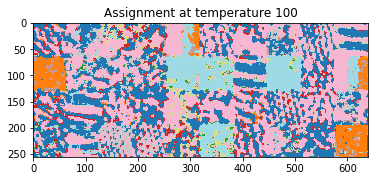

Temperature: 77.37809374999999


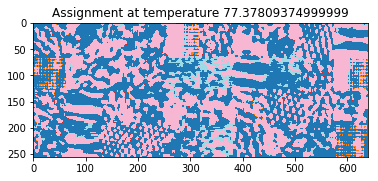

Temperature: 59.87369392383786


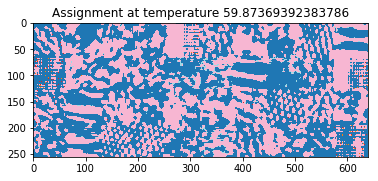

Temperature: 46.3291230159753


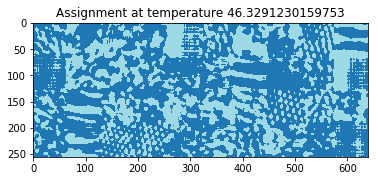

Temperature: 35.84859224085419


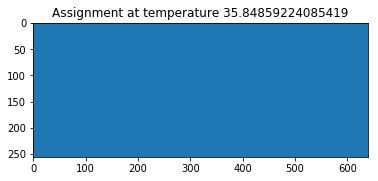

Temperature: 27.738957312183373


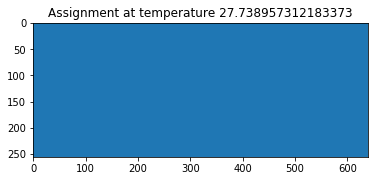

Temperature: 21.463876394293724


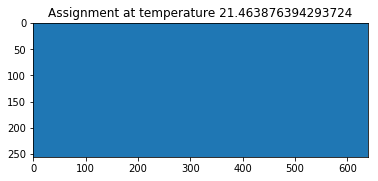

Temperature: 16.60833839876071


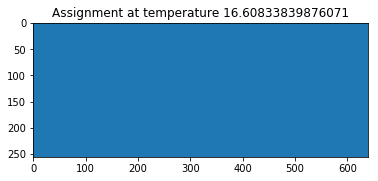

Temperature: 12.851215656510307


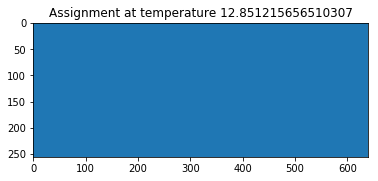

Temperature: 9.94402569870922


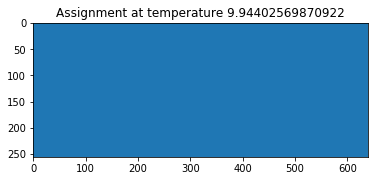

Temperature: 7.69449752767131


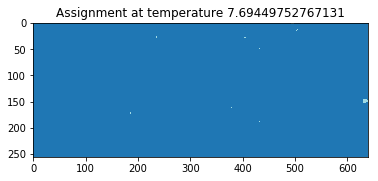

Temperature: 5.953855510552938


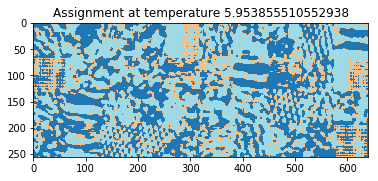

Temperature: 4.606979898695192


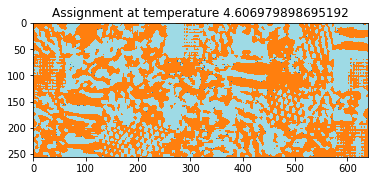

Temperature: 3.5647932250560204


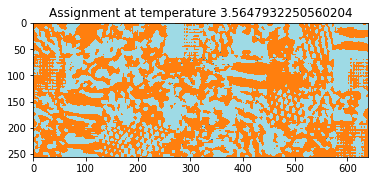

Temperature: 2.758369043677496


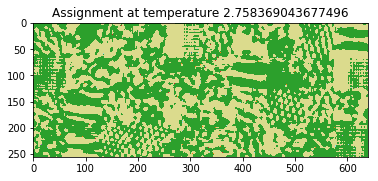

Temperature: 2.134373384587751


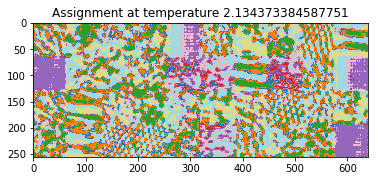

Temperature: 1.6515374385013575


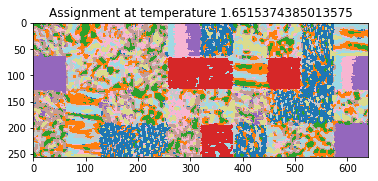

Temperature: 1.2779281874799289


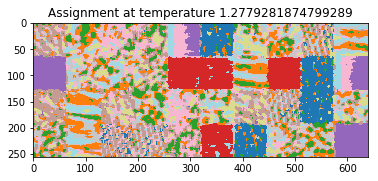

Temperature: 0.9888364709658948


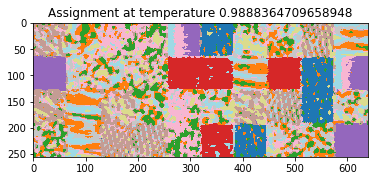

Temperature: 0.7651428115381814


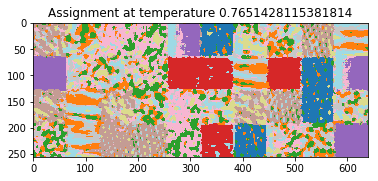

Temperature: 0.5920529220333998


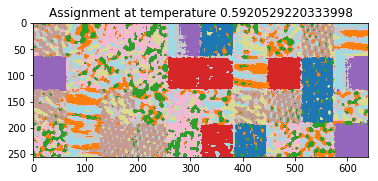

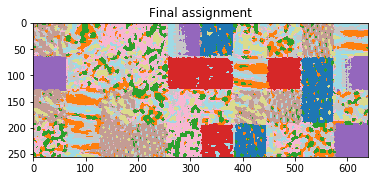

In [23]:
# Clustering at different temperatures
temperature = 5000
temp_decay = .95

X = (perm_texture * (HC.n_bins-1)).astype(np.uint8)

one_hot = np.zeros( (X.size, HC.n_bins))
one_hot[np.arange(X.size), X.ravel()] = 1
one_hot.shape = X.shape + (HC.n_bins,)

# scipy version needs to be >= 1.2.1 for fftconvolve to support axes keyword
cooccur = sp.sparse.csr_matrix(np.round(sps.fftconvolve(one_hot, np.ones((HC.window_size, HC.window_size, HC.n_bins)), 'same', axes=[0,1])).astype(int).reshape(-1, HC.n_bins))
x_occur = np.sum(cooccur, axis=-1).A
p_y_given_x = (cooccur / x_occur).A # shape (height * width, 256)
p_y_given_x += 1e-4
p_y_given_x /= np.sum(p_y_given_x, axis=1)[:, None]

for t in sorted(HC.histories.keys(), reverse=True):
    print('Temperature:', t)
    # shape (n_samples, n_centroids)
    kl = np.sum(p_y_given_x[:, None] * np.log(p_y_given_x[:, None] / HC.histories[t].T[None, :]), axis=-1)
    probs = np.exp(-x_occur * kl / t)
    probs /= np.sum(probs, axis=1)[:, None]
    
    assignments = np.argmax(probs, axis=-1)
    plt.figure()
    plt.imshow(assignments.reshape(perm_texture.shape), cmap='tab20')
    plt.title('Assignment at temperature {}'.format(t))
    plt.show()
        
kl = np.sum(p_y_given_x[:, None] * np.log(p_y_given_x[:, None] / HC.centroids.T[None, :]), axis=-1)
probs = np.exp(-x_occur * kl / t)
probs /= np.sum(probs, axis=1)[:, None]
assignments = np.argmax(probs, axis=-1)
plt.figure()
plt.imshow(assignments.reshape(perm_texture.shape), cmap='tab20')
plt.title('Final assignment')
plt.show()
        
plt.show()

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.